In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools
import time

In [2]:
# Завантаження даних Fashion-MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Нормалізація даних
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Перетворення міток у one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [44]:
# Назви класів в Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [59]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Ініціалізуємо початкові ваги і зсуви для всіх шарів
        self.input_size = input_size
        self.W1 = np.random.randn(input_size, hidden_size1)  / np.sqrt(input_size)  # Вага для першого шару
        self.b1 = np.zeros((1, hidden_size1))  # Зсув для першого шару
        self.W2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)  # Вага для другого шару
        self.b2 = np.zeros((1, hidden_size2))  # Зсув для другого шару
        self.W3 = np.random.randn(hidden_size2, output_size)  / np.sqrt(hidden_size2)  # Вага для вихідного шару
        self.b3 = np.zeros((1, output_size))  # Зсув для вихідного шару

    def softmax(self, x):
        # Функція softmax для нормалізації вихідних значень нейронної мережі
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
    def forward(self, X):
        # Пряме поширення даних через нейронну мережу
        X = X.reshape(X.shape[0], -1)  # Перетворення вхідних даних в плоский вигляд
        self.z1 = np.dot(X, self.W1) + self.b1  # Вхід на перший шар
        self.a1 = np.maximum(0, self.z1)  # Активація ReLU для першого шару
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Вхід на другий шар
        self.a2 = np.tanh(self.z2)  # Активація tanh для другого шару
        self.z3 = np.dot(self.a2, self.W3) + self.b3  # Вхід на вихідний шар
        self.a3 = self.softmax(self.z3)  # Активація softmax для вихідного шару
        return self.a3

    def backward(self, X, y_true):
        m = X.shape[0]
        # Обчислення похідних для ваг і зсувів для вихідного шару
        dz3 = self.a3 - y_true
        self.dW3 = (1 / m) * np.dot(self.a2.T, dz3)
        self.db3 = (1 / m) * np.sum(dz3, axis=0, keepdims=True)
        # Обчислення похідних для ваг і зсувів для другого прихованого шару
        dz2 = np.dot(dz3, self.W3.T) * (1 - np.square(np.tanh(self.z2)))
        self.dW2 = (1 / m) * np.dot(self.a1.T, dz2)
        self.db2 = (1 / m) * np.sum(dz2, axis=0, keepdims=True)
        # Обчислення похідних для ваг і зсувів для першого прихованого шару
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 > 0)
        self.dW1 = (1 / m) * np.dot(X.T, dz1)
        self.db1 = (1 / m) * np.sum(dz1, axis=0, keepdims=True)
        
    def update_param(self, lr):
        # Оновлення ваг і зсувів за допомогою градієнтного спуску
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2
        self.W3 -= lr * self.dW3
        self.b3 -= lr * self.db3

    def cross_entropy_loss(self, y_pred, y_true):
        # Обчислення крос-ентропії втрат і повернення середнього значення
        y_pred = np.clip(y_pred, 1e-10, 1.0)  # Запобігання логарифму від нуля
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def evaluate(self, X, y):
        # Обчислення втрат і точності
        predictions = self.forward(X)
        loss = self.cross_entropy_loss(predictions, y)  # Використання методу класу для крос-ентропії втрат
        accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))
        return loss, accuracy
    
    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate, batch_size=64):
        # Навчання моделі
        accuracy_history = []
        accuracy_history1 = []
        loss_history = []
        time_history = []
        tra = []  # Список для збереження точності на навчальних даних
        tesa = []  # Список для збереження точності на тестових даних
        for epoch in range(epochs):
            epoch_start_time = time.time()
            epoch_loss = 0
            train_accuracy = 0
            for i in range(0, X_train.shape[0], batch_size):
                batch_X = X_train[i:i + batch_size].reshape(-1, self.input_size)
                batch_y = y_train[i:i + batch_size]
                self.forward(batch_X)
                loss = self.cross_entropy_loss(self.a3, batch_y)  # Коректний виклик методу класу
                epoch_loss += loss
                self.backward(batch_X, batch_y)
                self.update_param(learning_rate)  # Передача коефіцієнта навчання
                train_accuracy += np.mean(np.argmax(self.a3, axis=1) == np.argmax(batch_y, axis=1))
            epoch_loss /= (X_train.shape[0] // batch_size)
            train_accuracy /= (X_train.shape[0] // batch_size)
            test_loss, test_accuracy = self.evaluate(X_test, y_test)
            tra.append(train_accuracy)
            tesa.append(test_accuracy)
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            time_history.append(epoch_time)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}, Time: {epoch_time:.2f} seconds")
        # Візуалізація точності
        fig, plot = plt.subplots()
        plot.plot(range(1, epochs + 1), tra, color="green", label="Train Accuracy")
        plot.plot(range(1, epochs + 1), tesa, color="red", label="Test Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

Epoch 1/25, Loss: 0.566, Train Accuracy: 0.799, Test Accuracy: 0.804, Time: 4.04 seconds
Epoch 2/25, Loss: 0.413, Train Accuracy: 0.852, Test Accuracy: 0.826, Time: 4.06 seconds
Epoch 3/25, Loss: 0.371, Train Accuracy: 0.865, Test Accuracy: 0.837, Time: 4.16 seconds
Epoch 4/25, Loss: 0.343, Train Accuracy: 0.874, Test Accuracy: 0.842, Time: 4.04 seconds
Epoch 5/25, Loss: 0.322, Train Accuracy: 0.882, Test Accuracy: 0.853, Time: 3.82 seconds
Epoch 6/25, Loss: 0.306, Train Accuracy: 0.888, Test Accuracy: 0.859, Time: 4.01 seconds
Epoch 7/25, Loss: 0.291, Train Accuracy: 0.892, Test Accuracy: 0.863, Time: 4.11 seconds
Epoch 8/25, Loss: 0.279, Train Accuracy: 0.897, Test Accuracy: 0.865, Time: 4.09 seconds
Epoch 9/25, Loss: 0.268, Train Accuracy: 0.901, Test Accuracy: 0.868, Time: 3.87 seconds
Epoch 10/25, Loss: 0.258, Train Accuracy: 0.906, Test Accuracy: 0.870, Time: 3.98 seconds
Epoch 11/25, Loss: 0.249, Train Accuracy: 0.909, Test Accuracy: 0.873, Time: 4.66 seconds
Epoch 12/25, Loss: 

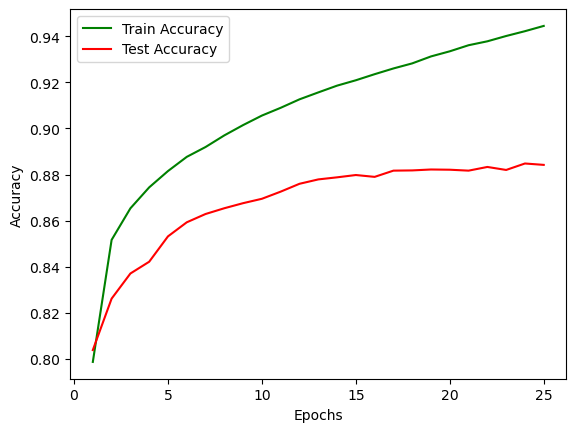

Test Loss: 0.3744059158053913
Test Accuracy: 0.8842


In [67]:
# Example usage:
model = NeuralNetwork(input_size=784, hidden_size1=256, hidden_size2=128, output_size=10)
model.train(X_train, y_train, X_test, y_test, epochs=25, learning_rate=0.1) 
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [36]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:",train_accuracy)

Train Loss: 0.22015424387325047
Train Accuracy: 0.9142833333333333


In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.3673764327170644
Test Accuracy: 0.8752


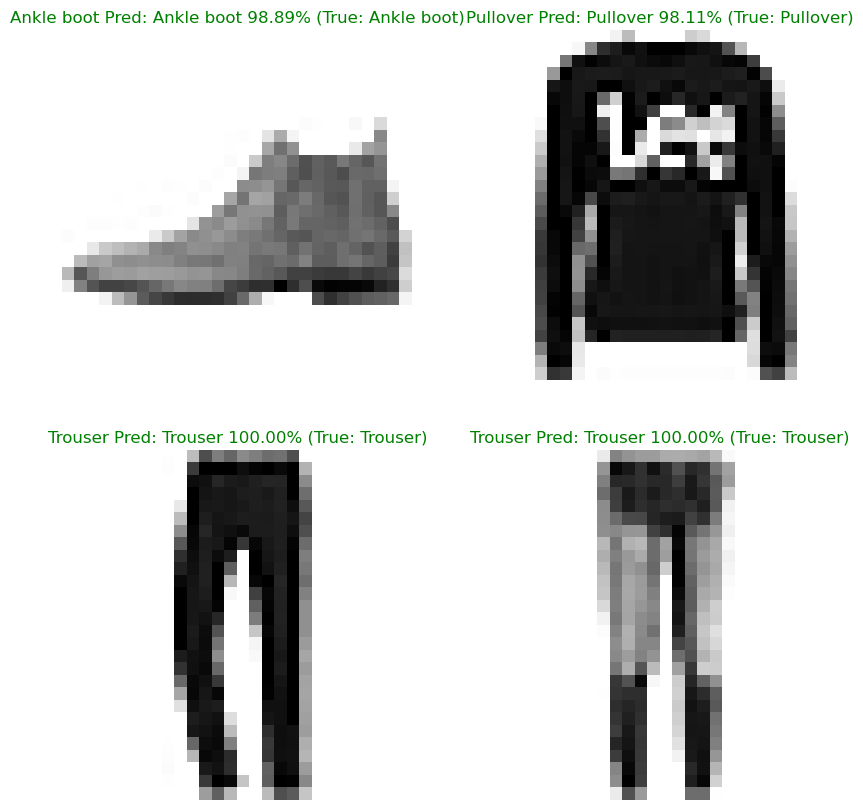

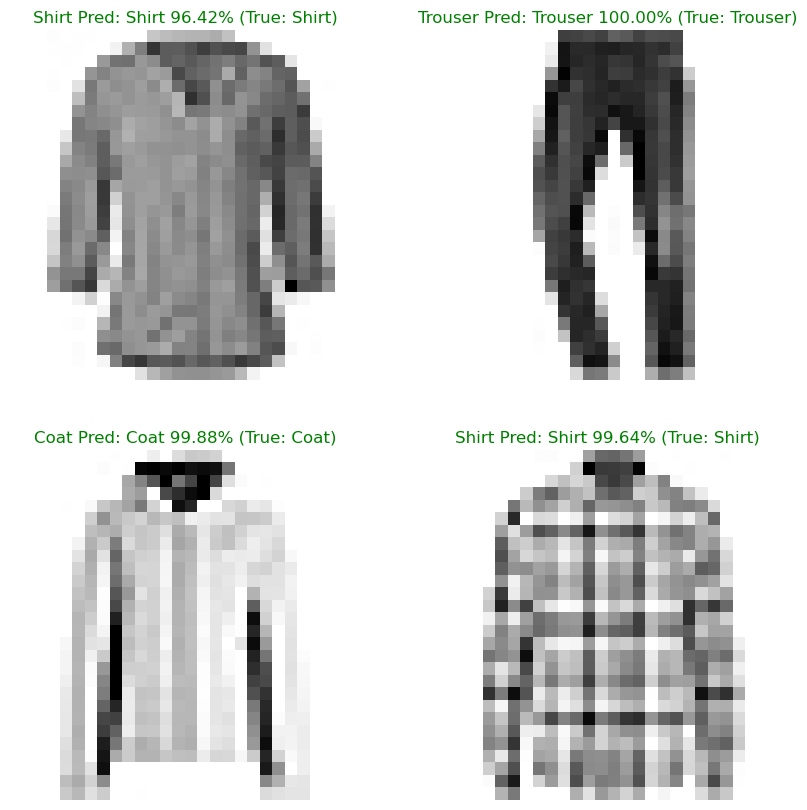

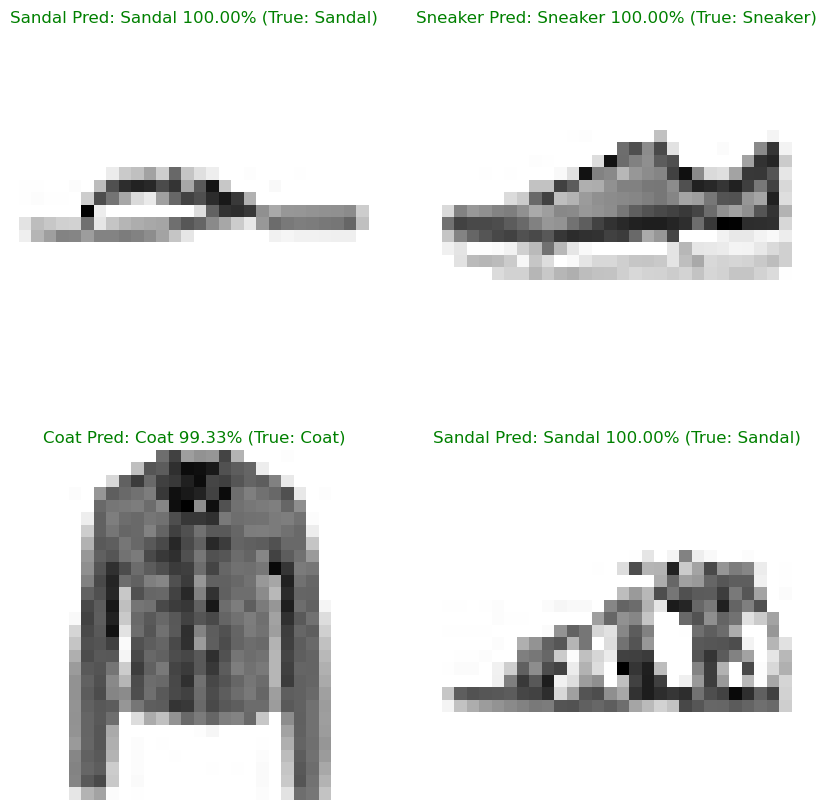

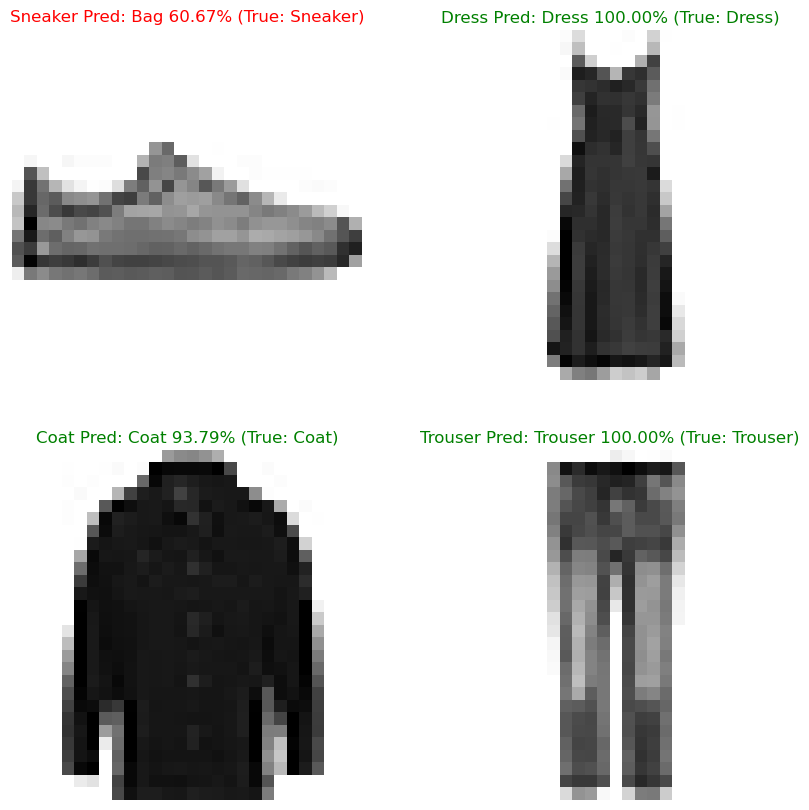

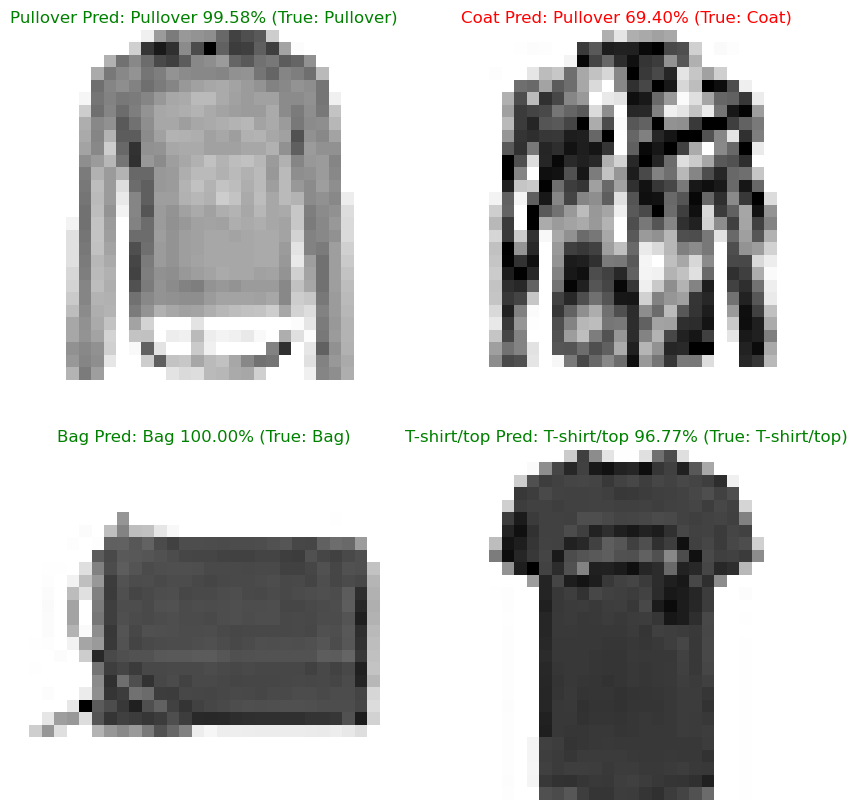

In [68]:
def plot_images(model_forward, images, true_labels, classes, num_images=20):
    num_figures = (num_images + 3) // 4
    for fig_num in range(num_figures):
        plt.figure(figsize=(10, 10))
        for i in range(4):
            index = fig_num * 4 + i
            if index >= num_images:
                break
            ax = plt.subplot(2, 2, i + 1)
            target_image = images[index]

            pred_probs = model_forward(target_image.reshape(1, 784))

            pred_label = classes[np.argmax(pred_probs)]
            true_label_index = np.argmax(true_labels[index])
            true_label = classes[true_label_index]

            plt.imshow(target_image, cmap=plt.cm.binary)

            if pred_label == true_label:
                color = "green"
            else:
                color = "red"

            plt.title(f"{true_label} Pred: {pred_label} {100*np.max(pred_probs):.2f}% (True: {true_label})", color=color)
            plt.axis(False)

# Виклик функції для відображення зображень
plot_images(model.forward, X_test, y_test, class_names)



confusion matrix

Normalized confusion matrix


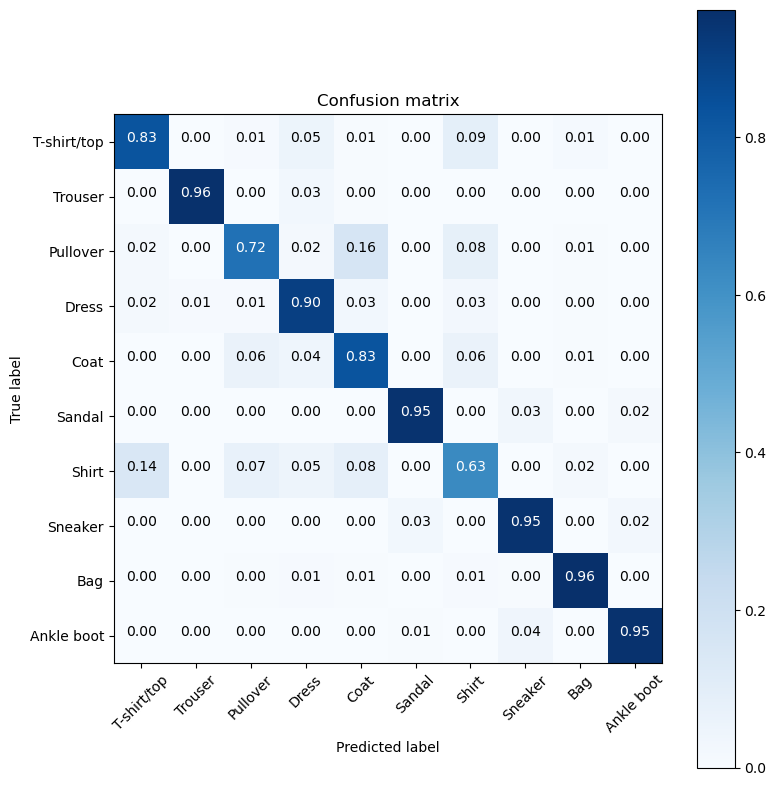

In [66]:
predictions = model.forward(X_test)
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Створення confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Функція для відображення confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Відображення confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()